In [24]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")  

Using GPU: NVIDIA GeForce RTX 5060


In [25]:
import joblib
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [26]:
train_data = pd.read_csv("C:\\Users\\kyle0\\OneDrive\\바탕 화면\\Kaggle\\Kaggle-Predicting_Loan_Payback\\playground-series-s5e11\\train.csv")
test_data = pd.read_csv("C:\\Users\\kyle0\\OneDrive\\바탕 화면\\Kaggle\\Kaggle-Predicting_Loan_Payback\\playground-series-s5e11\\test.csv")
print("Load All Data")

Load All Data


In [27]:
# Check first 5 rows 
train_data.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


# Check total rows, data types, and non-null counts for each feature 

In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [29]:
# Check categorical features

cat_attribs = train_data.select_dtypes(include=['object']).columns.tolist()
num_attribs = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for attrib in cat_attribs:
    print("Check [{}] feature:".format(attrib))
    print(train_data[attrib].value_counts())
    print('\n')

Check [gender] feature:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64


Check [marital_status] feature:
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64


Check [education_level] feature:
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64


Check [employment_status] feature:
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64


Check [loan_purpose] feature:
loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64


Check [grade_subgrade] feature:
grade_subgrade
C

In [30]:
# Check summary statistics for numerical features
train_data.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442236,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


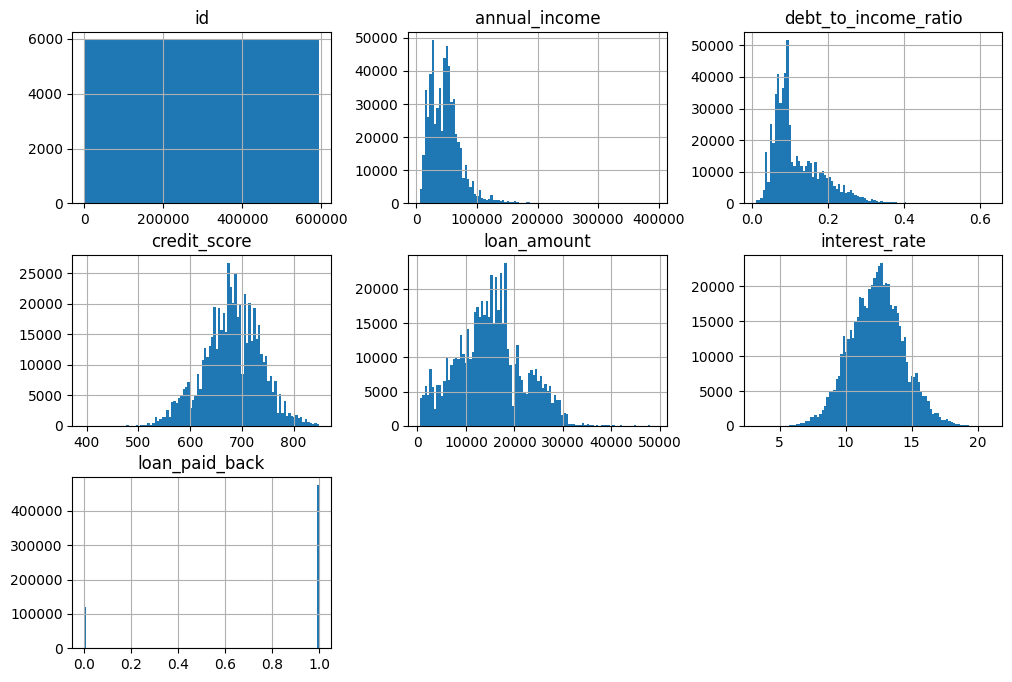

Log transformation is required for the annual_income feature and debt_to_income_ratio


In [31]:
# Draw histograms for numerical features.
train_data.hist(bins=100, figsize=(12, 8))
plt.show()

print("Log transformation is required for the annual_income feature and debt_to_income_ratio")

# EDA

In [32]:
train_data_copy = train_data.copy()

In [33]:
corr_matrix = train_data_copy.corr(numeric_only=True)
corr_matrix['loan_paid_back']

id                      0.001387
annual_income           0.006326
debt_to_income_ratio   -0.335680
credit_score            0.234560
loan_amount            -0.003762
interest_rate          -0.131184
loan_paid_back          1.000000
Name: loan_paid_back, dtype: float64

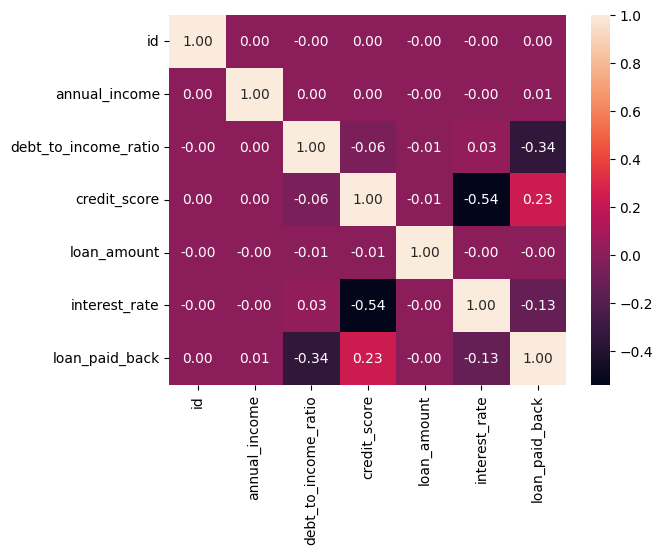

In [34]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Data Preprocessing

In [35]:
train_X = train_data_copy.drop("loan_paid_back", axis=1)
train_y = train_data_copy["loan_paid_back"].copy()

# Store Ids
train_ids = train_data_copy["id"].copy()
train_X = train_X.drop("id", axis=1)

In [36]:
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, validate=True),
    StandardScaler(),
)

preprocessing = ColumnTransformer([
        ("log",num_pipeline, ['annual_income','debt_to_income_ratio']),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=num_pipeline
)

In [37]:
train_prepared = preprocessing.fit_transform(train_X)
print("Preprocessing is completed.")
print("The shape of preprocessed training data: ", train_prepared.shape)
print(preprocessing.get_feature_names_out())

Preprocessing is completed.
The shape of preprocessed training data:  (593994, 60)
['log__annual_income' 'log__debt_to_income_ratio' 'cat__gender_Female'
 'cat__gender_Male' 'cat__gender_Other' 'cat__marital_status_Divorced'
 'cat__marital_status_Married' 'cat__marital_status_Single'
 'cat__marital_status_Widowed' "cat__education_level_Bachelor's"
 'cat__education_level_High School' "cat__education_level_Master's"
 'cat__education_level_Other' 'cat__education_level_PhD'
 'cat__employment_status_Employed' 'cat__employment_status_Retired'
 'cat__employment_status_Self-employed' 'cat__employment_status_Student'
 'cat__employment_status_Unemployed' 'cat__loan_purpose_Business'
 'cat__loan_purpose_Car' 'cat__loan_purpose_Debt consolidation'
 'cat__loan_purpose_Education' 'cat__loan_purpose_Home'
 'cat__loan_purpose_Medical' 'cat__loan_purpose_Other'
 'cat__loan_purpose_Vacation' 'cat__grade_subgrade_A1'
 'cat__grade_subgrade_A2' 'cat__grade_subgrade_A3'
 'cat__grade_subgrade_A4' 'cat__grade

In [41]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


RF_classifier = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
XGB_classifier = make_pipeline(preprocessing, XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.1, n_jobs=-1))
LGBM_classifier = make_pipeline(preprocessing, LGBMClassifier(n_estimators=100, random_state=42, learning_rate=0.1, n_jobs=-1))

print("Model training is completed.")



Model training is completed.


In [42]:
from sklearn.model_selection import cross_val_score

RF_scores = cross_val_score(
    estimator=RF_classifier, 
    X=train_X, 
    y=train_y, 
    cv=3, 
    scoring='roc_auc',  # AUC를 계산하도록 지정
    n_jobs=-1
)
print("\n--- RF_classifier AUC 결과 ---")
print("개별 폴드 AUC 점수:", RF_scores)
print(f"평균 교차 검증 AUC (CV={5}): **{RF_scores.mean():.4f}**")
print(f"점수의 표준 편차: {RF_scores.std():.4f}")
print("\n")

XGB_scores = cross_val_score(
    estimator=XGB_classifier, 
    X=train_X, 
    y=train_y, 
    cv=3, 
    scoring='roc_auc',  # AUC를 계산하도록 지정
    n_jobs=-1
)
print("\n--- XGB_classifier AUC 결과 ---")
print("개별 폴드 AUC 점수:", XGB_scores)
print(f"평균 교차 검증 AUC (CV={5}): **{XGB_scores.mean():.4f}**")
print(f"점수의 표준 편차: {XGB_scores.std():.4f}")
print("\n") 

LGBM_scores = cross_val_score(
    estimator=LGBM_classifier, 
    X=train_X, 
    y=train_y, 
    cv=3, 
    scoring='roc_auc',  # AUC를 계산하도록 지정
    n_jobs=-1
)
print("\n--- LGBM_classifier AUC 결과 ---")
print("개별 폴드 AUC 점수:", LGBM_scores)
print(f"평균 교차 검증 AUC (CV={5}): **{LGBM_scores.mean():.4f}**")
print(f"점수의 표준 편차: {LGBM_scores.std():.4f}")
print("\n") 


--- RF_classifier AUC 결과 ---
개별 폴드 AUC 점수: [0.90471203 0.90437234 0.90576432]
평균 교차 검증 AUC (CV=5): **0.9049**
점수의 표준 편차: 0.0006



--- XGB_classifier AUC 결과 ---
개별 폴드 AUC 점수: [0.91648873 0.91766899 0.91852096]
평균 교차 검증 AUC (CV=5): **0.9176**
점수의 표준 편차: 0.0008



--- LGBM_classifier AUC 결과 ---
개별 폴드 AUC 점수: [0.9188096  0.91894064 0.92026946]
평균 교차 검증 AUC (CV=5): **0.9193**
점수의 표준 편차: 0.0007




In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(train_y, RF_classifier.predict_proba()[:, 1])

# plt.plot(fpr, tpr, label="ROC 곡선")
# plt.xlabel("FPR")
# plt.ylabel("TPR (재현율)")
# # 0 근처의 임계값을 찾습니다
# close_zero = np.argmin(np.abs(thresholds))
# plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
#          label="임계값 0", fillstyle="none", c='k', mew=2)
# plt.legend(loc=4)
# plt.show() 